In [1]:
import joblib
import torch
import numpy as np
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from DF_model_Torch import DF
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
setup_seed(42)

In [2]:
model_path = './trained_model/AWF_775_model.pt'
checkpoint = torch.load(model_path)
feature_model = DF(64)
feature_model.cuda()
feature_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [4]:
def create_test_set_AWF_open(features_model,dataset,shot,size,class_num):
    n_query = 70
    knn = joblib.load(f'./trained_model/knn_model_{dataset}_{shot}.pkl')
    train_name = f'/root/datasets/FSCIL/{dataset}.npz'
    train_dataset = np.load(train_name,allow_pickle=True)
    train_data = train_dataset['data']
    train_labels = train_dataset['labels']
    if( shot == 20 and dataset == 'KNN'):
        X_test = train_data
        y_test = train_labels
    else:
        X_train,X_test, y_train, y_test =train_test_split(train_data,train_labels,test_size=(shot+n_query)*class_num, random_state=42,shuffle=True,stratify=train_labels)
    y_test = np.array([lab for lab in y_test])
    unique = np.unique(y_test)
    unique = unique[np.random.permutation(unique.shape[0])]
    labels = []
    proba = []
    for cla in unique:
        inds_train = np.argwhere(y_test==cla)

        samples_train = inds_train.reshape(-1)
        
        query = np.array(X_test[samples_train][shot:])
        query = query.reshape(query.shape[0],1,query.shape[1])

        query = torch.tensor(query,dtype=torch.float32).cuda()
        features_model.eval()
        with torch.no_grad():
            proba.extend(knn.predict_proba(np.array(features_model(query).cpu())))
            labels.extend([1 for i in range(n_query)])
    print(len(proba))
    train_name = f'/root/datasets/FSCIL/AWF_{size}.npz'
    train_dataset = np.load(train_name,allow_pickle=True)
    train_data = train_dataset['data']
    for i in range(0,size,200):
        query = np.array(train_data[i:i+200])
        query = query.reshape(query.shape[0],1,query.shape[1])
        query = torch.tensor(query,dtype=torch.float32).cuda()
        features_model.eval()
        with torch.no_grad():
            proba.extend(knn.predict_proba(np.array(features_model(query).cpu())))
            labels.extend([0 for i in range(200)])
    print(len(proba))
    return proba, labels
def cross_entropy(predictions, targets):
    epsilon = 1e-12  # 添加一个小的常数，避免log(0)的情况

    predictions = np.clip(predictions, epsilon, 1.0 - epsilon)  # 限制预测值的范围
    ce = -np.sum(targets * np.log(predictions), axis=1)  # 计算交叉熵

    return ce

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve,roc_auc_score
for size in [50000,100000,200000,400000]:
    size = size
    class_num = 100
    prob,lab = create_test_set_AWF_open(feature_model,'DF19',10,size,class_num)
    if(size == 400000):
        for i in range(11):
            lab.pop()
        tol = 70*class_num+size-11
    else:
        tol = 70*class_num+size
    prob = np.array(prob)
    ll = np.ones([tol, class_num])
    va = cross_entropy(prob,ll)

    precision, recall, thresholds = precision_recall_curve(lab,va)
    # plt.plot(recall, precision)
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.title('Precision-Recall Curve')
    # plt.show()
    print(roc_auc_score(lab,va))

7000
57000
0.9663724114285716
7000
107000
0.9663572499999998
7000
207000
0.96643236
7000
406989
0.9664379388290321


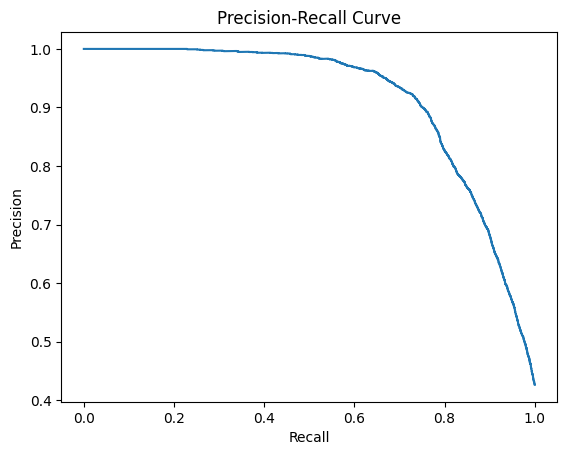

0.9125182623224729

In [39]:

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve,roc_auc_score
precision, recall, thresholds = precision_recall_curve(lab,va)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
roc_auc_score(lab,va)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.20246156, 0.19466791,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])